In [2]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')


In [3]:
import pandas as pd
import numpy as np
import torch 
from torch import from_numpy
import torch.nn as nn
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from torch.utils.data import TensorDataset, DataLoader
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [4]:
nasnet_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/nasnet_mobile.keras'
nasnet_mobile = load_model(nasnet_path)

resnet50v1_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet_50v1.keras'
resnet50 = load_model(resnet50v1_path)

resnet101v2_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/resnet101v2.keras'
resnet101v2 = load_model(resnet101v2_path)

convnext = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
convnext.classifier = nn.Sequential(
    nn.Flatten(),     
    
    #FC 1                       
    nn.Linear(in_features=768, out_features=64),   
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout1d(p=0.3), 
           
    #FC 2                                           
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(), 
    nn.BatchNorm1d(32),  
    nn.Dropout1d(p=0.3), 
    
    #Softmax
    nn.Linear(in_features=32, out_features=6),  
    nn.Softmax(dim=1)                                           
)


for param in convnext.features.parameters(): 
    param.requires_grad = False

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
convnext = convnext.to(device)

# Load the saved weights
checkpoint = torch.load('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/convnext_model.pth', weights_only=False)
convnext.load_state_dict(checkpoint['model_state_dict'])

2024-11-25 13:43:51.190010: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-25 13:43:51.190029: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-25 13:43:51.190033: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-25 13:43:51.190046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:43:51.190057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<All keys matched successfully>

In [5]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= False, seed = 1, target_size=(256, 256))

#Tensorflow setup
X_test, y_test = test_splits(test)

#Torch setup 
X_test_torch = from_numpy(X_test.numpy()).permute(0, 3, 1, 2)
y_test_torch = from_numpy(y_test.numpy())

test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [6]:
feature_extractor_nasnet = Model(inputs=nasnet_mobile.input, outputs=nasnet_mobile.get_layer('global_average_pooling2d').output)
feature_extractor_pred_nasnet = feature_extractor_nasnet.predict(X_test)

feature_extractor_resnet50 = Model(inputs=resnet50.input, outputs=resnet50.get_layer('avg_pool').output)
feature_extractor_pred_resnet50 = feature_extractor_resnet50.predict(X_test)

feature_extractor_resnet101 = Model(inputs=resnet101v2.input, outputs=resnet101v2.get_layer('avg_pool').output)
feature_extractor_pred_resnet101 = feature_extractor_resnet101.predict(X_test)

class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x.view(x.size(0), -1)  

# Create feature extractor
feature_extractor = FeatureExtractor(convnext)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  

# Extract features
features = []
with torch.no_grad():
    for inputs, _ in test_loader: 
        inputs = inputs.to(device)
        batch_features = feature_extractor(inputs)
        features.extend(batch_features.cpu().numpy())

feature_extractor_pred_convnext = np.array(features)


2024-11-25 13:44:02.312990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 411ms/step


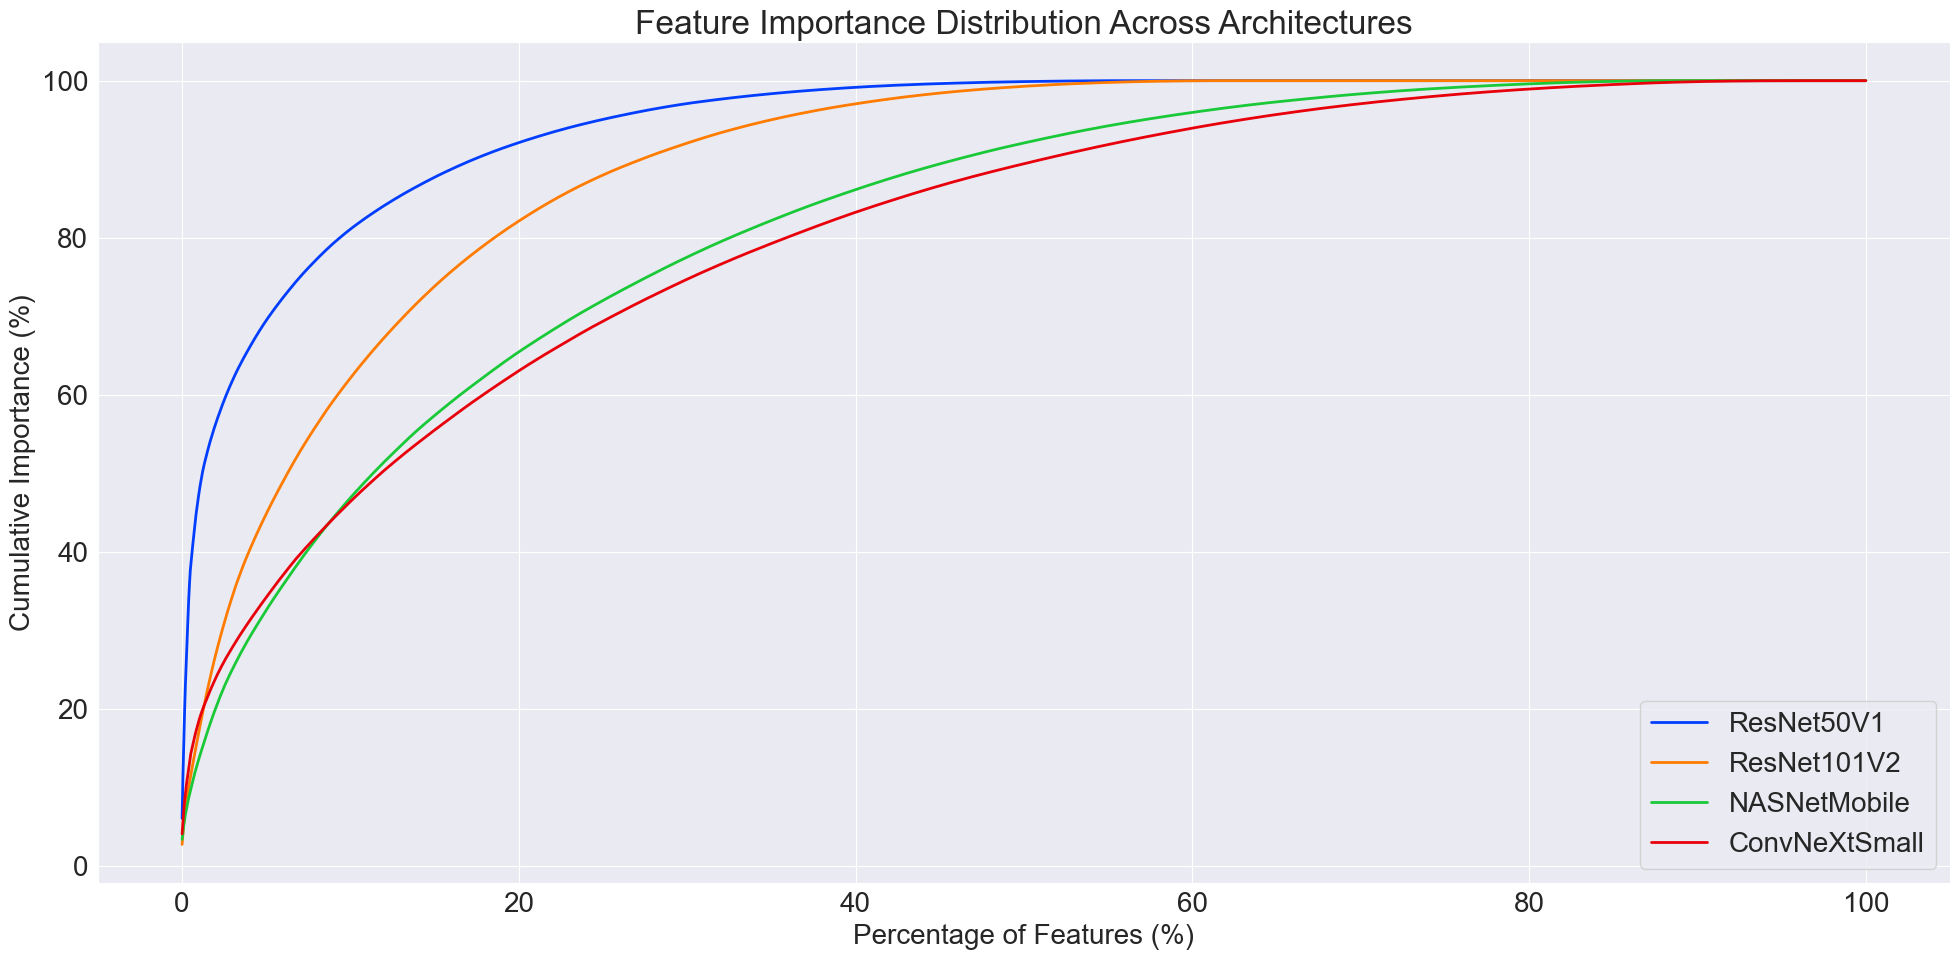

In [14]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({'font.size': 20})
sns.set_style('darkgrid')

extracted_features = [ 
    (feature_extractor_pred_resnet50, 'ResNet50V1'), 
    (feature_extractor_pred_resnet101, 'ResNet101V2'), 
    (feature_extractor_pred_nasnet, 'NASNetMobile'), 
    (feature_extractor_pred_convnext, 'ConvNeXtSmall')
]

y_true = pd.Series(tf.argmax(y_test, axis=1).numpy())

class_labels = list(test.class_indices.keys())
class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true.map(class_mapping)


plt.figure(figsize=(20, 10))

for pred, name in extracted_features:
    scaler = StandardScaler()
    pred_scale = scaler.fit_transform(pred)
    pred_df = pd.DataFrame(pred_scale)
    
    xgb = XGBClassifier()
    xgb.fit(pred_df, y_true)
    feature_importances = pd.Series(xgb.feature_importances_).sort_values(ascending=False)
    
    x_normalized = np.linspace(0, 100, len(feature_importances))
    cumulative_importances = feature_importances.cumsum() * 100  
    
    sns.lineplot(x=x_normalized, y=cumulative_importances, label=name, linewidth=2)

plt.xlabel('Percentage of Features (%)')
plt.ylabel('Cumulative Importance (%)')
plt.title('Feature Importance Distribution Across Architectures')
plt.legend()
plt.tight_layout()
sns.set_palette('bright')  

image_output_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/generated_images'
plot_output = os.path.join(image_output_dir, 'feature_importance_distributions.png')
#plt.savefig(plot_output)

plt.show()

In [8]:
results = []

for pred, name in extracted_features:
    scaler = StandardScaler()
    pred_scale = scaler.fit_transform(pred)
    pred_df = pd.DataFrame(pred_scale)
    
    xgb = XGBClassifier()
    xgb.fit(pred_df, y_true)
    feature_importances = pd.Series(xgb.feature_importances_).sort_values(ascending=False)
    
    n_features = len(feature_importances)
    percentage_5 = feature_importances.head((n_features // 20)).sum() * 100
    percentage_10 = feature_importances.head((n_features // 10)).sum() * 100
    percentage_25 = feature_importances.head((n_features // 4)).sum() * 100
    
    results.append({
        'Architecture': name,
        'Number of features': n_features,
        'Top 5%': f'{round(percentage_5)}',
        'Top 10%': f'{round(percentage_10)}',
        'Top 25%': f'{round(percentage_25)}'
    })

results_df = pd.DataFrame(results)
results_df['Number of features'] = results_df['Number of features'].map('{:,}'.format)

display(results_df)

,Architecture,Number of features,Top 5%,Top 10%,Top 25%
0,ResNet50V1,"2,048",69,81,95
1,ResNet101V2,"2,048",45,62,88
2,NASNetMobile,"1,056",32,47,72
3,ConvNeXtSmall,768,34,46,69


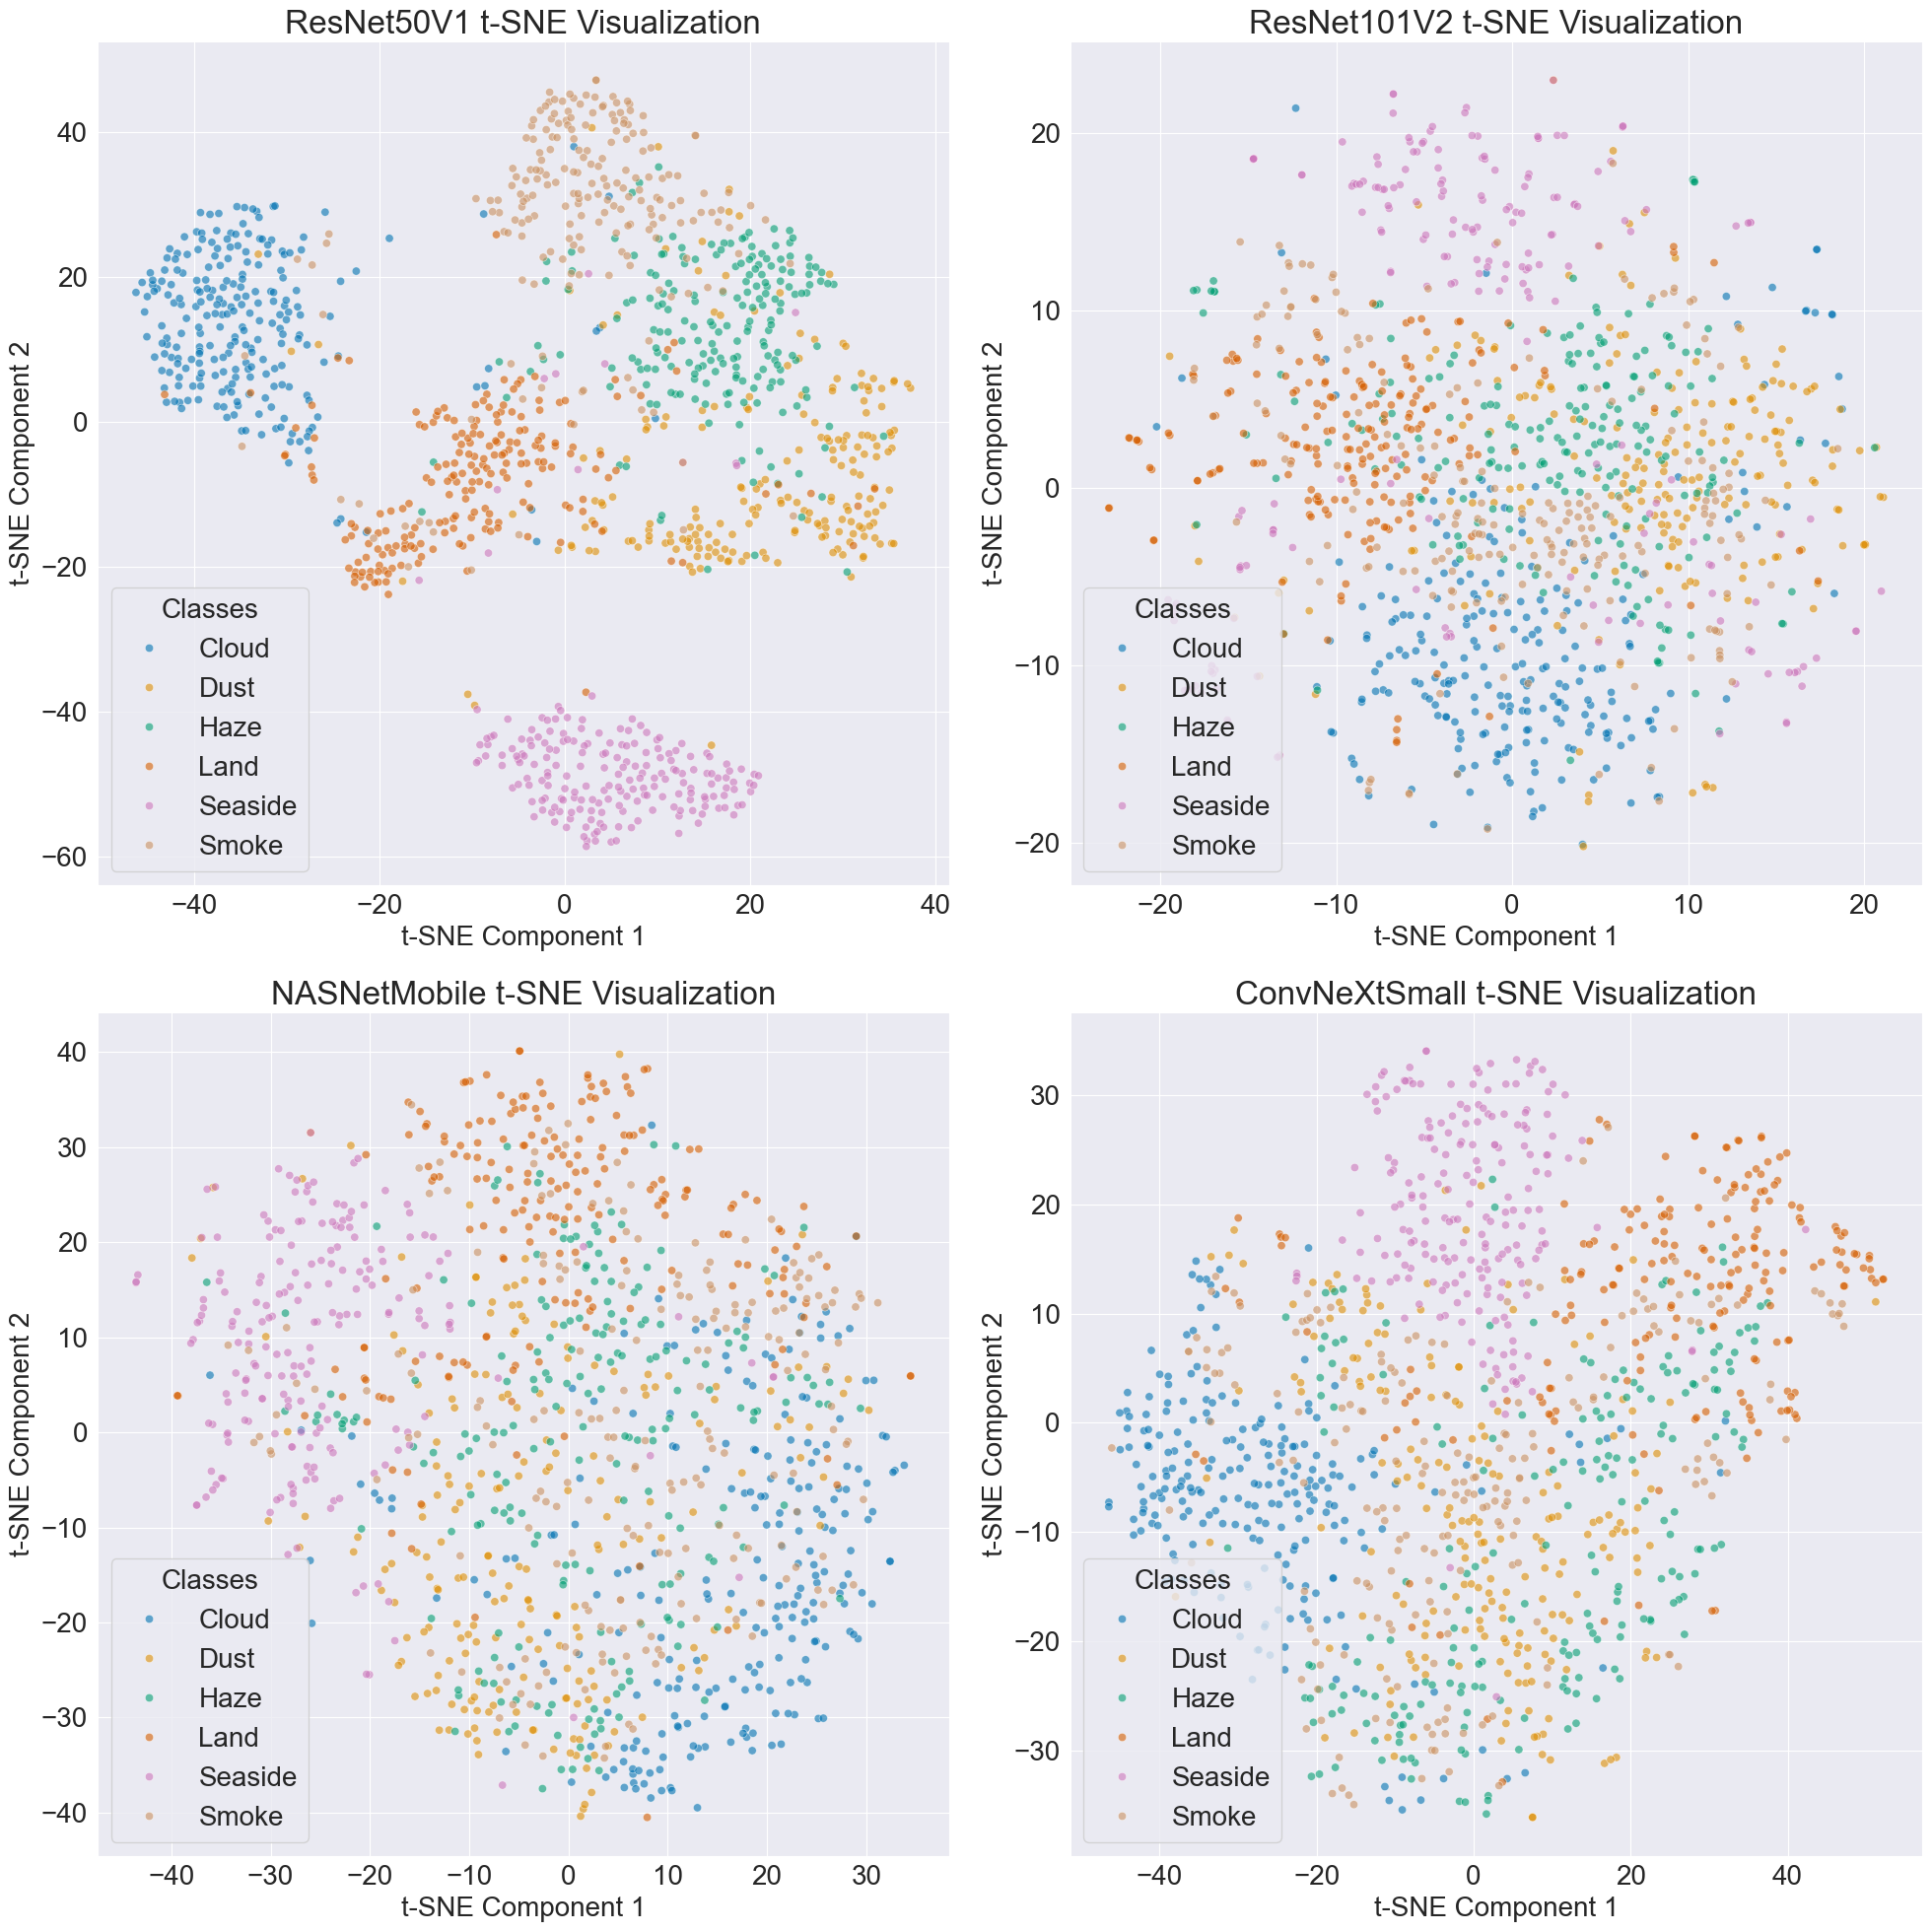

In [20]:
from sklearn.manifold import TSNE
plt.figure(figsize=(20, 20))


class_labels = list(test.class_indices.keys())
class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true.map(class_mapping)


for idx, (pred, name) in enumerate(extracted_features, 1):
    plt.subplot(2, 2, idx)
    
    scaler = StandardScaler()
    pred_scale = scaler.fit_transform(pred)
    
    tsne = TSNE(n_components=2, random_state=1, perplexity=30, 
                max_iter=2000, learning_rate='auto', init='pca')
    X_tsne = tsne.fit_transform(pred_scale)
    
    tsne_df = pd.DataFrame({
        'x1': X_tsne[:, 0],
        'x2': X_tsne[:, 1],
        'class': y_true
    })
    

    sns.scatterplot(data=tsne_df, x='x1', y='x2', hue= y_true_labels, 
                    palette='colorblind', alpha=0.6)
    plt.title(f'{name} t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    plt.legend(loc='lower left', title='Classes')
    
plt.tight_layout()

image_output_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/generated_images'
plot_output = os.path.join(image_output_dir, 'tsne_visualizations.png')
plt.savefig(plot_output)

plt.show()